In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as sp
import seaborn as sns
import glob
import subprocess
import os

import rdkit
from rdkit import Chem
from rdkit.Chem import Draw
from rdkit.Chem import rdmolops
from rdkit import DataStructs
from rdkit.Chem import AllChem
from rdkit.ML.Cluster import Butina
from rdkit.Chem.Scaffolds import MurckoScaffold
from rdkit.Chem.Draw import rdMolDraw2D
from sklearn.cluster import AgglomerativeClustering
from PIL import Image

# shut off warnings
from rdkit import RDLogger                                                                                                                                                               
RDLogger.DisableLog('rdApp.*')  

import matplotlib
from matplotlib import rc
font = {'size'   : 8}
matplotlib.rc('font', **font)

# change font
matplotlib.rcParams['font.sans-serif'] = "Arial"
matplotlib.rcParams['font.family'] = "sans-serif"

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import plotly.express as px
import molplotly

palette = {'Original Screen': 'grey', 'ML Curation': 'cornflowerblue'}

# Part 1: Define antibiotic similarity function - using new abx dataset

In [2]:
# for every molecule, get similarity to closest drug in a set of drug fps
def get_lowest_tanimoto_from_drug_set_to_abx(new_set):
    # new_set is list of smiles
    # drug_fps is list of fingerprints of things you want to compare to
    mols = [Chem.MolFromSmiles(x) for x in new_set]
    fps = [Chem.RDKFingerprint(x) for x in mols]

    best_similarity = []
   
    abx = pd.read_csv('../data/curated_set_of_566_abx.csv')
    print('number of abx: ', len(abx))

    abx_mols = [Chem.MolFromSmiles(smi) for smi in list(abx['Smiles'])]
    keep_indices = [m is not None for m in abx_mols]
    abx = abx[keep_indices]
    abx_mols = [m for i,m in enumerate(abx_mols) if keep_indices[i]]
    drug_fps = [Chem.RDKFingerprint(x) for x in abx_mols]
    
    i = 0
    for mol in fps:
        curr_highest_sim = 0
        j = 0
        for drug in drug_fps:
            sim = DataStructs.FingerprintSimilarity(mol,drug)
            if sim > curr_highest_sim and i !=j:
                curr_highest_sim = sim
            j = j + 1
        best_similarity.append(curr_highest_sim)
        i = i + 1 
    return(best_similarity)

def compute_highest_tan_sim_to_abx(smis):
    smis = [smi for smi in smis if type(smi) != float]
    mols = [Chem.MolFromSmiles(x) for x in smis]
    fps = [Chem.RDKFingerprint(x) if x is not None else '' for x in mols ]
    tans = get_lowest_tanimoto_from_drug_set_to_abx(smis)
    return(tans)

# Part 2: Read in all 100 hits, primary screen + ML curated

100
number of abx:  566
84
16


/Users/jackie16201/opt/anaconda3/envs/chemprop010821/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning: 29.8% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


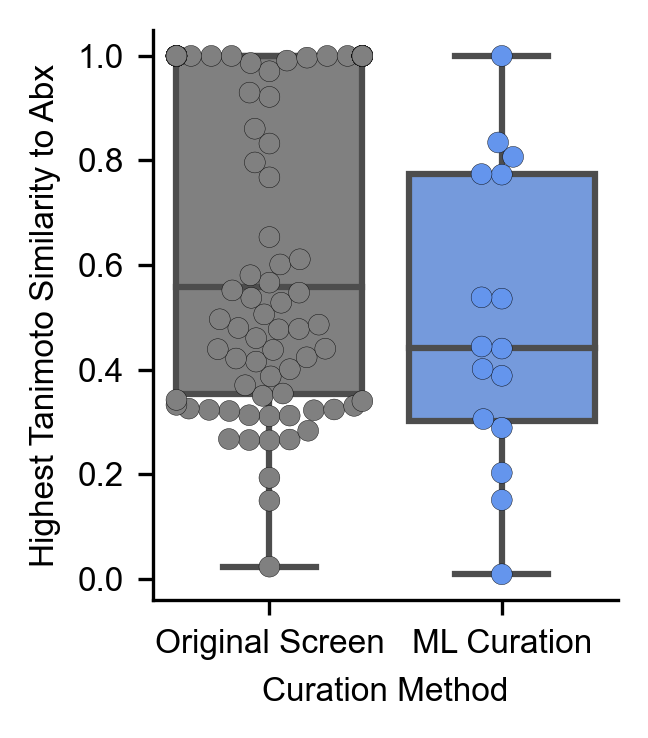

MannwhitneyuResult(statistic=476.5, pvalue=0.03187893471970578)

In [3]:
df = pd.read_csv('../data/training_plus_ml_curation_hits.csv')
print(len(df))
tans = compute_highest_tan_sim_to_abx(list(df['SMILES']))

tans84 = tans[0:84]
print(len(tans84))

tans16 = tans[84:100]
print(len(tans16))

tandf = pd.DataFrame()
labels = ['Original Screen'] * len(tans84)
labels.extend(['ML Curation'] * len(tans16))
tandf['Highest Tanimoto Similarity to Abx'] = tans
tandf['Curation Method'] = labels

fig, ax = plt.subplots(figsize = (2.2,2.5), dpi = 300)
ax = sns.boxplot(data = tandf, x = 'Curation Method', y = 'Highest Tanimoto Similarity to Abx', palette = palette)
sns.swarmplot(data = tandf, x = 'Curation Method', y = 'Highest Tanimoto Similarity to Abx', ax = ax, linewidth = 0.1, edgecolor = 'black', palette = palette)
plt.xlabel('Curation Method')
plt.ylabel('Highest Tanimoto Similarity to Abx')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.tight_layout()
plt.savefig('../figure_panels/2H_ml_cpds_vs_orig_cpds_abx_similarity.png')
plt.show()

orig = tandf[tandf['Curation Method'] == 'Original Screen']
ml = tandf[tandf['Curation Method'] == 'ML Curation']
sp.mannwhitneyu(list(orig['Highest Tanimoto Similarity to Abx']), list(ml['Highest Tanimoto Similarity to Abx']))

# Part 3: Perform the same experiment for non-toxic cpds

In [4]:
tox_data = groundtruth = pd.read_excel('../data/10 uM tox.xlsx')
groundtruth['HepG2'] = [np.mean([x,y]) for x,y in zip(list(groundtruth.iloc[:,1]), list(groundtruth.iloc[:,2]))]
groundtruth['HEK293'] = [np.mean([x,y]) for x,y in zip(list(groundtruth.iloc[:,3]), list(groundtruth.iloc[:,4]))]
groundtruth = groundtruth[['Unnamed: 0', 'HepG2', 'HEK293']]
groundtruth.columns = ['Broad_ID', 'HepG2', 'HEK293']

# get predictions along with their Broad IDs to merge on
mapped_names = pd.read_excel('../data/TrainingDataRound1_wValidation.xlsx')
mapped_names = mapped_names[['Sample', 'Name']]
mapped_names.columns = ['Broad_ID', 'Name']

df = pd.read_csv('../data/training_plus_ml_curation_hits.csv')
orig = df.merge(mapped_names, on = 'Name')
val = df[['BRD' in x for x in list(df['Name'])]]
val['Broad_ID'] = val['Name']
df = pd.concat([orig,val])

df = df[['SMILES', 'Name', 'Broad_ID']]

# clean names to standardize
df['Broad_ID'] = [x.split('-')[0] + '-' + x.split('-')[1] for x in list(df['Broad_ID'])]
groundtruth['Broad_ID'] = [x.split('-')[0] + '-' + x.split('-')[1] for x in list(groundtruth['Broad_ID'])]

# merged tox dataframe
toxdf = df.merge(groundtruth, on = 'Broad_ID')
toxdf['Curation Method'] = ['Original Screen' if 'BRD' not in x else 'ML Curation' for x in list(toxdf['Name'])]

justnontox = toxdf[toxdf['HepG2'] > 0.5]
justnontox = justnontox[justnontox['HEK293'] > 0.5]
print(len(justnontox))
justnontox

50


/var/folders/py/8hwb28r933z4xh4q0dw5hz2h0000gn/T/ipykernel_82322/3182375329.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val['Broad_ID'] = val['Name']
/var/folders/py/8hwb28r933z4xh4q0dw5hz2h0000gn/T/ipykernel_82322/3182375329.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  groundtruth['Broad_ID'] = [x.split('-')[0] + '-' + x.split('-')[1] for x in list(groundtruth['Broad_ID'])]


,SMILES,Name,Broad_ID,HepG2,HEK293,Curation Method
2,CC[C@@H](C)CCCCC(=O)N[C@@H](CCN)C(=O)N[C@@H]([...,polymyxin-B-sulfate,BRD-A08641215,1.085333,0.919343,Original Screen
4,NC[C@H]1O[C@H](O[C@@H]2[C@@H](N)C[C@@H](N)[C@H...,bekanamycin,BRD-K73425385,1.138278,0.906419,Original Screen
6,CNC[C@@H]1CC[C@@H](N)[C@@H](O[C@@H]2[C@@H](N)C...,micronomicin,BRD-K18552138,1.261710,1.016640,Original Screen
7,CCCCCCCCCCCCC[N+](C)(C)Cc1ccccc1,benzalkonium,BRD-K34234316,0.830129,0.850539,Original Screen
9,Oc1cc(Cl)ccc1Oc1ccc(Cl)cc1Cl,triclosan,BRD-K41731458,1.354185,0.993971,Original Screen
10,[O-][N+](=O)c1ccc(\C=C\C=N\N2CC(=O)NC2=O)o1,furagin,BRD-K00003314,1.069809,0.955981,Original Screen
13,[H][C@@](CCNCS(O)(=O)=O)(NC(=O)CCCC(C)C)C(=O)N...,colistimethate,BRD-K01666924,1.350019,1.050155,Original Screen
14,[H][C@@]1(CC[C@@]2([H])[C@]3([H])[C@H](O)C[C@@...,trodusquemine,BRD-K00003124,1.145481,0.934506,Original Screen
15,OCC(Br)(CO)[N+]([O-])=O,bronopol,BRD-K33457401,0.956861,0.586218,Original Screen
18,Nc1ccc(cc1)S(=O)(=O)N([Ag])c1ncccn1,silver-sulfadiazine,BRD-K68379918,0.779246,0.904882,Original Screen


number of abx:  566


/Users/jackie16201/opt/anaconda3/envs/chemprop010821/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning: 31.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


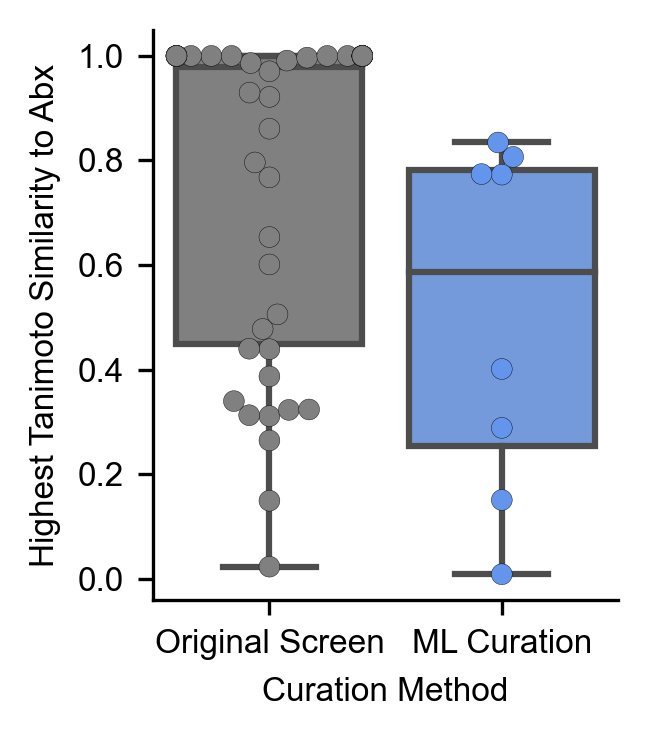

MannwhitneyuResult(statistic=80.0, pvalue=0.008862285468951042)

In [5]:
tans = compute_highest_tan_sim_to_abx(list(justnontox['SMILES']))
justnontox['Highest Tanimoto Similarity to Abx'] = tans

fig, ax = plt.subplots(figsize = (2.2,2.5), dpi = 300)
ax = sns.boxplot(data = justnontox, x = 'Curation Method', y = 'Highest Tanimoto Similarity to Abx', palette = palette)
sns.swarmplot(data = justnontox, x = 'Curation Method', y = 'Highest Tanimoto Similarity to Abx', linewidth = 0.1, edgecolor = 'black',ax = ax, palette = palette)
plt.xlabel('Curation Method')
plt.ylabel('Highest Tanimoto Similarity to Abx')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.tight_layout()
plt.savefig('../figure_panels/3D_nontoxic_ml_cpds_vs_orig_cpds_abx_similarity.png')
plt.show()

orig = justnontox[justnontox['Curation Method'] == 'Original Screen']
ml = justnontox[justnontox['Curation Method'] == 'ML Curation']

sp.mannwhitneyu(list(orig['Highest Tanimoto Similarity to Abx']), list(ml['Highest Tanimoto Similarity to Abx']))